# Analysis of Solar System Moons

In this notebook, we are going to be leveraging data analysis to extract some interesting insights from a dataset that describes the natural satellites (fancy science-y word for moons) in the Solar System. 

For the analysis, we will be using some of Python's most popular libraries - numpy, pandas, and re, for data manipulation and matplotlib and seaborn for visualizing the data. So let's dive in.

In [1]:
#Import the libraries that support the functionalities we require for analysis 
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import re

## Getting the data

The data we are going to be analyzing is in a Wikipedia page. So let's load the data from the webpage into a pandas dataframe.

In [2]:
#Loading all tables in URL into df_main
df_main = pd.read_html('https://en.wikipedia.org/wiki/List_of_natural_satellites#List', header = 0)
#Loading the 6th table which has details of each moon in the Solar System into df
df = df_main[5]
#Printing the first 10 rows
# df.head(10)

Now we shall look at some basic information about the data loaded into the dataframe.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 11 columns):
Image                                   1 non-null object
Parent                                  219 non-null object
Numeral                                 219 non-null object
Name                                    219 non-null object
Mean radius (km)                        219 non-null object
Semi-major axis (km)                    219 non-null object
Sidereal period (d) (r = retrograde)    219 non-null object
Discovery year                          219 non-null object
Discovered by                           218 non-null object
Notes                                   212 non-null object
Ref(s)                                  217 non-null object
dtypes: object(11)
memory usage: 18.9+ KB


### Observations

- There are a total of 11 columns and 219 rows
- All the columns are of object datatype - this means some type conversion has to be done for further analysis
- The column 'Image' is empty since the original table in the Wikipedia page had images of the respective moon in each row - We can remove this column 
- 'Ref(s)' column has numbers which are essentially hyperlinks to appropriate sources of information for the details in that particular row - The numbers by themselves might not be too helpful so we can remove this as well 
- The columns are ordered in a haphazard manner - The table is about the different moons of planets in the Solar System but the names of the moons are in the third column instead of the first - This placement of information can be hard for the human eye to navigate and make logical sense of quickly

## Acting on the observations

#### Dropping redundant columns

We can drop the 'Image' and 'Ref(s)' columns as in this environment, we can't extract useful information from the data in them.

In [4]:
df = df.drop(['Image', 'Ref(s)'], axis = 1)

#### Renaming the columns for ease of interpretation

This is one of our first step before jumping into data analysis since,
1. the names of columns should be self-explanatory for anyone who goes through the data without having to do a Wikipedia/Google search
2. names that are too complicated or long can prove arduous when making references to them during data manipulation tasks.

The columns can be renamed like so -

- 'Parent': 'Parent_Planet' - Parent can mean anything; Parent_Planet adds context 
- 'Numeral': 'Orbital_Position' - Numeral on its own doesn't make sense - Numerals are deignated based on orbital order by convention (https://en.wikipedia.org/wiki/Naming_of_moons#Roman_numeral_designations)
- 'Name': 'Moon_Name'
- 'Discovery year': 'Yr_of_Discovery'
- 'Mean radius (km)': 'Mean_Radius_KM'
- 'Semi-major axis (km)': 'MajorOrbitalAxis_HalfLength' - Major Axis corresponds to the larger axis of the satellite's orbit; And semi-major axis is half the length of the major axis 
- 'Sidereal period (d) (r = retrograde)': 'Days_to_Orbit_once' - Sidereal period is the number of days a satellite takes to complete one orbit around its parent planet
- 'Discovered by': 'Discoverer'

In [5]:
#Renaming the columns appropriately
df = df.rename(columns={'Parent': 'Parent_Planet', 'Numeral': 'Orbital_Position', 'Name': 'Moon_Name', 'Discovery year': 'Yr_of_Discovery', 'Mean radius (km)': 'Mean_Radius_KM', 'Semi-major axis (km)': 'MajorOrbitalAxis_HalfLength', 'Sidereal period (d) (r = retrograde)': 'Days_to_Orbit_once', 'Discovered by': 'Discoverer'})
# df.head()

#### Reordering the columns to make logical sense

The current ordering of the columns has the name of the parent planet first. This might confuse a person who comes to look at the data expecting to see the data of the moons.

The ordering can be like this -

The basic identifiers:
- 'Moon_Name' - This should come first because this is the main subject about which the other columns are present to describe   
- 'Parent_Planet' - Should come second because a) we first have to know which planet the moon belongs to before moving on to other details and b) data in the parent planet is what everyone is most familiar with
- 'Orbital_Position' - Once we know the name of the moon and which planet it belongs to, it helps to know which position it is in (especially when looking at multiple rows and making comparisons)

Discovery:

'Yr_of_Discovery'  followed by 'Discoverer' - These two columns can come next as they're related (obviously) and can provide a little bit of factual context about their discovery before moving on to the numerical/scientific parameters 

The physics aspects: Once we know the basic information about the moon and its discovery, we can then look at the (slightly) more complex details like 
- 'Days_to_Orbit_once'  
- 'Mean_Radius_KM'  
- 'MajorOrbitalAxis_HalfLength'   

Miscellaneous: Any extra information can come last
- 'Notes'  

In [6]:
#Reordering the columns
df = df[['Moon_Name', 'Parent_Planet', 'Orbital_Position', 'Yr_of_Discovery', 'Discoverer', 'Days_to_Orbit_once', 'Mean_Radius_KM', 'MajorOrbitalAxis_HalfLength', 'Notes']]
# df.head()

#### Setting an index

Say I want to find the name of the person who discovered Europa, Jupiter's 2nd moon. This can be hard because I do not know the exact row index. For this reason, let's set an index that is convenient for accessing information based on the moon's name in the rest of the notebook. 

But we are not sure if the names of all moons are unique. What if the 5th moon of Jupiter and Saturn have the same name? Let's find out if the number of unique values in the Moon_Name is equal to 219. If yes, then all moons have unique names and this can be used as our index column. If not, we set the Moon_Name and Parent_Planet together as index columns.

In [7]:
#Count unique values in Moon_Name column
df['Moon_Name'].nunique()

219

As all the moon names are unique, we can set this column alone as the index.

In [8]:
#Setting Moon_Name column as index
df = df.set_index('Moon_Name')
# df.head()

## Data Cleaning

While the data is not exactly messy, there are columns in the data that are not in a desirable form for analysis. So now, we shall take care of that by doing some data cleaning.

#### Type Conversion

As noted in the observations, all the columns in the dataframe are of the object datatype. So first, we shall perfor some type conversions such that it is easy for performing appropriate manipulations to the values in the column.

- Parent_Planet has a finite number of values that can be assumed so it can be converted to the 'category' type - Could be useful when creating visualizations
- Orbital_Position can be left as is as we are going to be cleaning it further using some regex
- Yr_of_Discovery can be converted to numeric; Moon's Yr_of_Discovery can be changed to 0 in the interest of uniformity - We can bin the years to see how many moons were discovered in different periods
- Discoverer can be left as is
- Days_to_Orbit_once can be left as is since it has an '(r)' at the end of some values - We need to clean this and then convert to numeric; MajorOrbitalAxis_HalfLength also has some error tolerance terms which should be cleaned so it can be left as object type; Same applies to 'Mean_Radius_KM' 
- Notes can be left as is

In [9]:
#Making type conversions of the columns
df['Parent_Planet'] = df['Parent_Planet'].astype('category')
df['Yr_of_Discovery'].loc['Moon'] = 0
df['Yr_of_Discovery'] = df['Yr_of_Discovery'].apply(pd.to_numeric, errors = 'coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, Moon to Dysnomia
Data columns (total 8 columns):
Parent_Planet                  219 non-null category
Orbital_Position               219 non-null object
Yr_of_Discovery                217 non-null float64
Discoverer                     218 non-null object
Days_to_Orbit_once             219 non-null object
Mean_Radius_KM                 219 non-null object
MajorOrbitalAxis_HalfLength    219 non-null object
Notes                          212 non-null object
dtypes: category(1), float64(1), object(6)
memory usage: 24.7+ KB


C:\Users\Sahitya\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Cleaning the Orbital_Position column

This column has the Roman Numeral along with the regular numeric notation within brackets. For ease of manipulation, we can clean the column such that we have the number within brackets alone.

In [10]:
df['Orbital_Position'] = df['Orbital_Position'].str.extract(r"\((.*)\)")
# df.head()

#### Cleaning the Mean_Radius_KM and MajorOrbitalAxis_HalfLength columns

These columns have a numeric value and in some cases, an additional error tolerance. While this is important information, for EDA, a ballpark value should be sufficient. So let's remove this part of the string which starts with the '±' character. 

In [11]:
df['Mean_Radius_KM'] = df['Mean_Radius_KM'].str.split('±').str[0]
df['MajorOrbitalAxis_HalfLength'] = df['MajorOrbitalAxis_HalfLength'].str.split('±').str[0]
# df

Scrolling through the data shows that values with 4 or more digits have commas in them. These need to be removed.
Further, some values have a few characters to denote approximations such as ~, <, and >. These can be removed using the replace method. The column can then be converted to numeric.

In [12]:
df['Mean_Radius_KM'] = df['Mean_Radius_KM'].str.replace(',|<|>|~','').str.lstrip().str.rstrip()
df['Mean_Radius_KM'] = pd.to_numeric(df['Mean_Radius_KM'], errors='coerce')
df['MajorOrbitalAxis_HalfLength'] = df['MajorOrbitalAxis_HalfLength'].str.replace(',|<|>|~','').str.lstrip().str.rstrip()
df['MajorOrbitalAxis_HalfLength'] = pd.to_numeric(df['MajorOrbitalAxis_HalfLength'], errors='coerce')

#### Cleaning the Days_to_Orbit_once column and creating a new column for direction of rotation

This column has values with (r) in some rows to denote that the satellite is moving in a direction opposite to its parent planet. This is useful information that can be extracted from the column and populated in a new column. The new column can be called 'Follows_Parent_Planet' wherein if the value is 1, it means that the moon is moving in the same direction as its parent planet, and 0 otherwise (retrogade).

In [13]:
#Create a new column called 'Follows_Parent_Planet'
df['Follows_Parent_Planet'] = ~df['Days_to_Orbit_once'].str.contains('(r)')
df['Follows_Parent_Planet'] = df['Follows_Parent_Planet']*1
#Clean the 'Days_to_Orbit_once'
df['Days_to_Orbit_once'] = df['Days_to_Orbit_once'].str.replace(',|<|>|~|\(r\)','').str.lstrip().str.rstrip()
df['Days_to_Orbit_once'] = pd.to_numeric(df['Days_to_Orbit_once'], errors='coerce')
#Reorder the columns such that 'Follows_Parent_Planet' comes before 'Days_to_Orbit_once'
df = df[['Parent_Planet', 'Orbital_Position', 'Yr_of_Discovery', 'Discoverer', 'Follows_Parent_Planet', 'Days_to_Orbit_once', 'Mean_Radius_KM', 'MajorOrbitalAxis_HalfLength', 'Notes']]

C:\Users\Sahitya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


## Exploratory Data Analysis

First, some descriptive statistics about the numerical features in the dataset

In [14]:
cols = ['Days_to_Orbit_once', 'Mean_Radius_KM', 'MajorOrbitalAxis_HalfLength']
df[cols].describe()

,Days_to_Orbit_once,Mean_Radius_KM,MajorOrbitalAxis_HalfLength
count,219.000000,219.00000,2.190000e+02
mean,673.566321,230.43621,1.338397e+07
std,1000.773882,1767.72415,1.048475e+07
min,0.294000,0.15000,1.827830e+01
25%,6.132000,2.00000,2.299700e+05
50%,631.600000,4.00000,1.800900e+07
75%,908.815000,30.00000,2.240334e+07
max,9373.990000,25657.00000,4.838700e+07


### When has moon discovery been at its peak? 

The Universe is an ever-expanding mystery but we humans first need to know for sure if we've got our own Solar System fully figured out. So let's first find out if the majority of the discovery of the natural satellites of all the 9 (or 8) planets is long past or there's possibility for more. 

We need to first bin the Yr_of_Discovery column into specific periods so that we can draw more insights about each period.

In [15]:
#Ignoring the moon's year of discovery as it is an obvious outlier
df['Yr_of_Discovery'].loc['Phobos':].describe()

count     216.000000
mean     1975.601852
std        80.984689
min      1610.000000
25%      1986.000000
50%      2002.500000
75%      2006.000000
max      2019.000000
Name: Yr_of_Discovery, dtype: float64

In [16]:
year_bins=np.array([1610.,1700.,1800.,1900.,2000., 2020.])
year_names = ['1610-1700', '1700-1800','1800-1900','1900-2000', '2000-Present']
df['Discovery_Period']=pd.cut(df['Yr_of_Discovery'],year_bins,labels=year_names,include_lowest=True)

Now we shall plot to find the period of surge in discovery of moons overall.

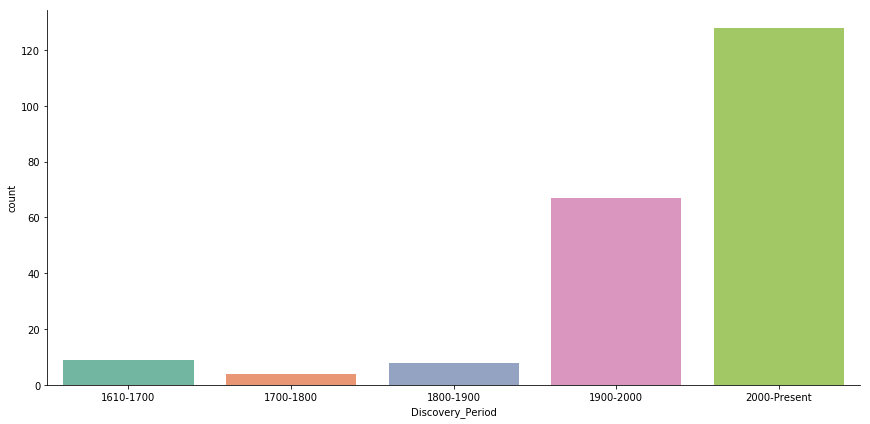

In [17]:
g = sns.catplot(x="Discovery_Period", 
                data=df, kind = 'count',
                height=6, aspect=2, palette = "Set2", ci=None)

Majority of the discoveries have happened in recent years. That makes sense as discovery of new heavenly bodies is a function of technological advancement.

We could further see how the progress in discovery has been like for different planets in the solar system.

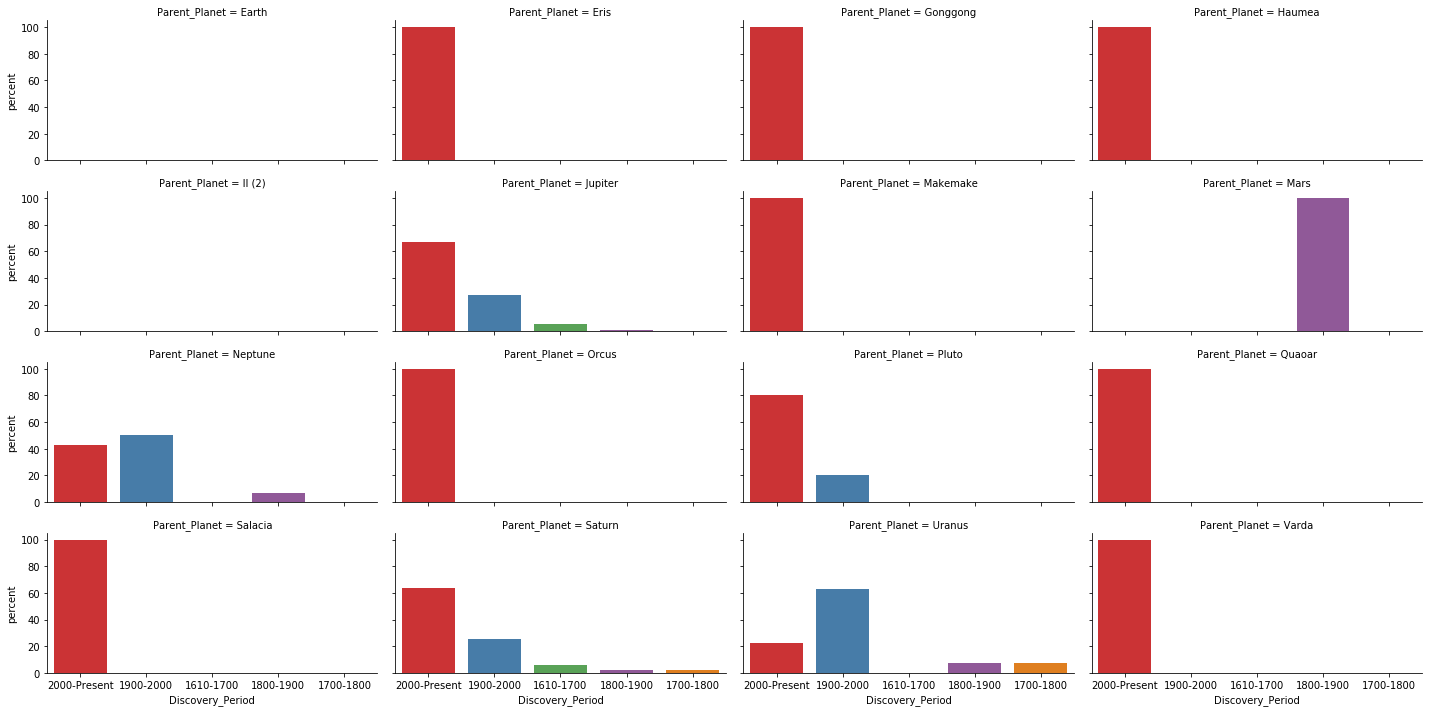

In [18]:
x,y = 'Parent_Planet', 'Discovery_Period'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x="Discovery_Period", y="percent", col="Parent_Planet", col_wrap=4,
                data=df1, kind = 'bar',
                height=2.5, aspect=2, palette = "Set1", ci=None)

Looks like we had discovered many of the moons of Uranus and Neptune and some of Jupiter and Saturn in the 1900-2000 period.

### Prograde Vs Retrogade

A Wikipedia article states that majority of the natural satellites are in prograde motion (follow the direction of the parent planet).
The ones that are in retrogade motion are usually small and farther from the parent planet. 
Since we have the data with us, we can visualize this and find the moons that are outliers to this assertion.

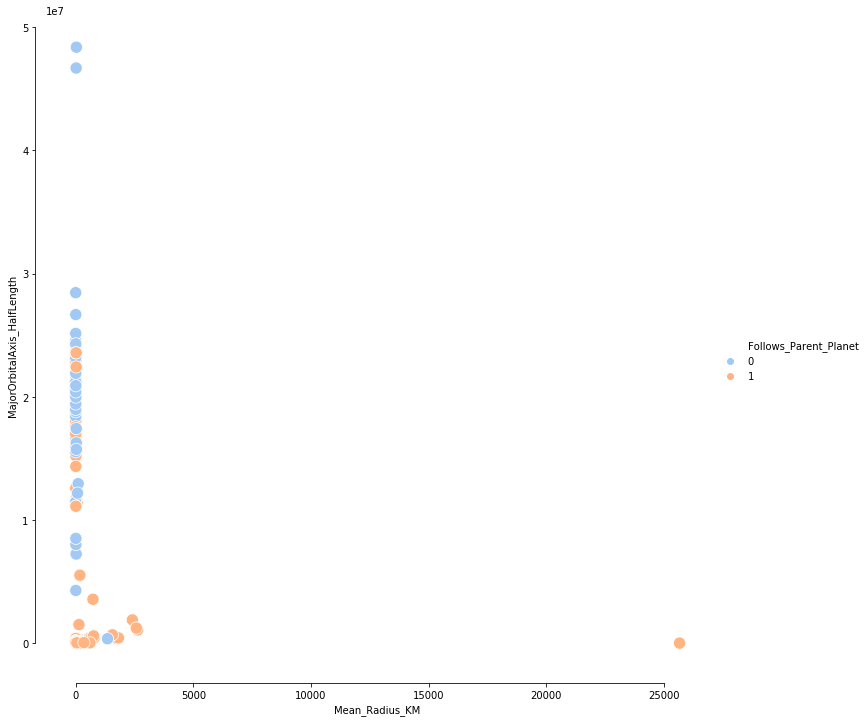

In [19]:
p1 = sns.relplot(x="Mean_Radius_KM", y="MajorOrbitalAxis_HalfLength", hue="Follows_Parent_Planet", 
            palette="pastel",
            height=10, s=150, data=df)
sns.despine(offset=10, trim=True);

This is not too insightful as the scale is quite long-tailed. Let's try using a log scale for more clarity.

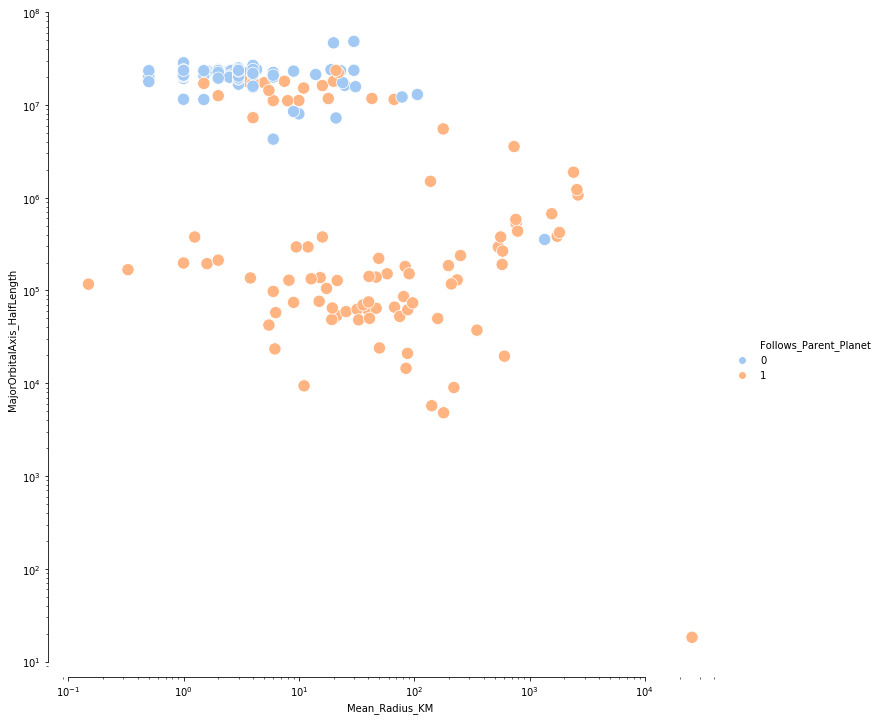

In [20]:
p2 = sns.relplot(x="Mean_Radius_KM", y="MajorOrbitalAxis_HalfLength", hue="Follows_Parent_Planet", 
            palette="pastel",
            height=10, s=150, data=df)
p2.set(xscale="log", yscale="log")
sns.despine(offset=10, trim=True);

It indeed is true. Retrogade moons are smaller and farther except for one moon. Let's try to find out which one that is.

In [21]:
df[(df['Mean_Radius_KM'] > 1000) & (df['Follows_Parent_Planet'] == 0)]

,Parent_Planet,Orbital_Position,Yr_of_Discovery,Discoverer,Follows_Parent_Planet,Days_to_Orbit_once,Mean_Radius_KM,MajorOrbitalAxis_HalfLength,Notes,Discovery_Period
Moon_Name,,,,,,,,,,
Triton,Neptune,1,1846.0,Lassell,0,5.877,1353.4,354800.0,Retrograde irregular,1800-1900


#### So which planets have such unruly moons?

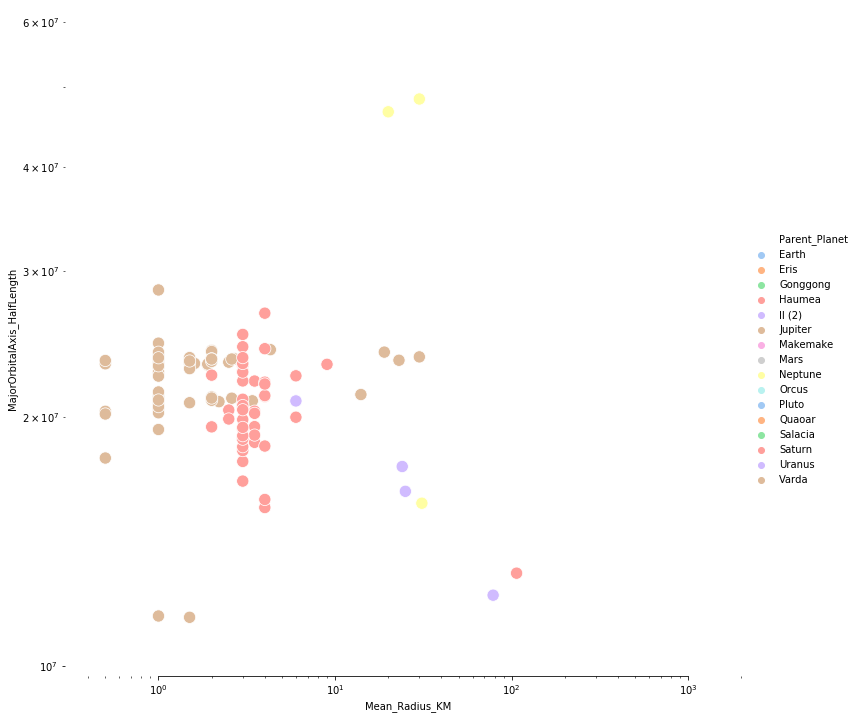

In [22]:
p3 = sns.relplot(x="Mean_Radius_KM", y="MajorOrbitalAxis_HalfLength", hue="Parent_Planet", 
            palette="pastel",
            height=10, s=150, data=df[df['Follows_Parent_Planet'] == 0])
p3.set(xscale="log", yscale="log", ylim=(10000000,None))
sns.despine(offset=10, trim=True);

It looks like Jupiter, Saturn, and Neptune have several moons in retrograde motion.

#### What about the ones that follow their parent planets?

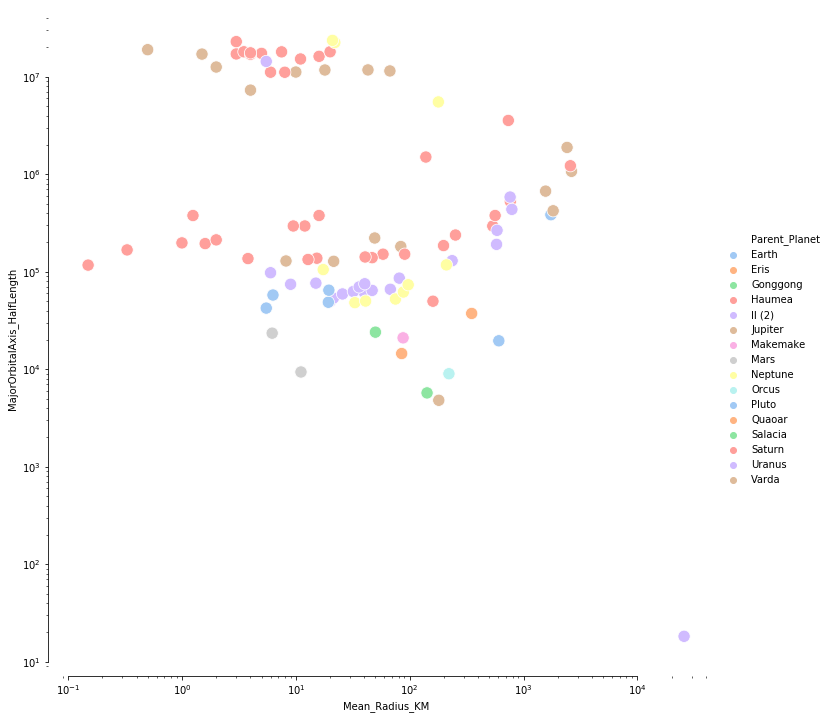

In [23]:
p4 = sns.relplot(x="Mean_Radius_KM", y="MajorOrbitalAxis_HalfLength", hue="Parent_Planet", 
            palette="pastel",
            height=10, s=150, data=df[df['Follows_Parent_Planet'] == 1])
p4.set(xscale="log", yscale="log")
sns.despine(offset=10, trim=True);

It is once again Jupiter, Neptune, and Uranus. This could be because of the large number of moons discovered orbiting these planets. This calls for some bar plotting to compare the relative volume of natural satellites in prograde and retrogade motion for each planet. 

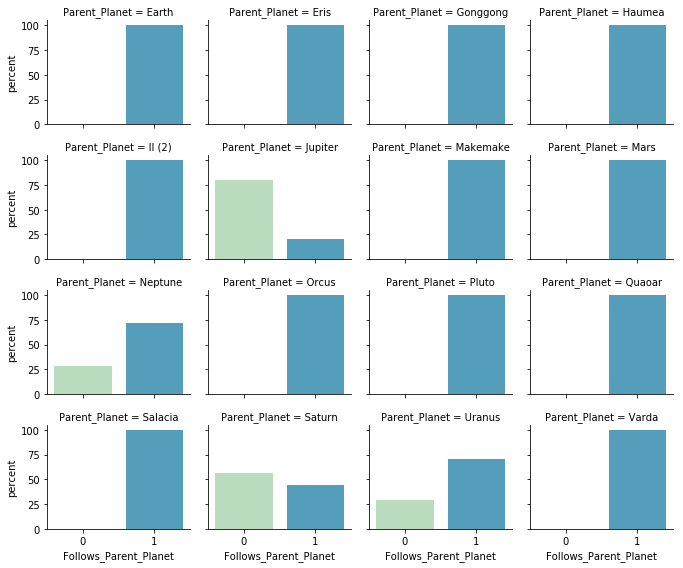

In [24]:
x,y = 'Parent_Planet', 'Follows_Parent_Planet'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x="Follows_Parent_Planet", y="percent", col="Parent_Planet", col_wrap=4,
                data=df1, kind = 'bar',
                height=2, aspect=1.2, palette = "GnBu", ci=None)

Indeed, it is these planets (Saturn, Jupiter, Neptune, and Uranus) that have a significant percentage moons moving in a direction opposite to their motion. 

## Conclusions

Based on our analysis, it seems like we have just started picking up speed in terms of discovery of natural satellites to the planets in our solar system which is a humbling reminder that we have a very very long way to go in space exploration.

Another interesting insight is about the behaviour of natural satellites belonging to different planets. Planets like Jupiter, Neptune, and Saturn have half (or more in Jupiter's case) of their moons moving in a direction opposite to theirs. This should sure have implications on the dynamics of the respective parent planets which in turn could impact the gravitational waves of the Solar System. This might be something astrophysicists can study further. 